## Load data

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
from os import path
import json
from ast import literal_eval
import matplotlib.pyplot as plt
import matplotlib

plt.style.use("bmh")
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)
all_colors = [parameter['color'] for parameter in plt.rcParams['axes.prop_cycle']]

In [4]:
from scipy import signal
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer
from public_MAPE import score_function
from sklearn.model_selection import learning_curve, validation_curve

In [5]:
data_dir = "../data"

train = pd.read_csv(path.join(data_dir, "train_input.csv"), sep=';', index_col=0)
test = pd.read_csv(path.join(data_dir, "test_input.csv"), sep=';', index_col=0)
ages = pd.read_csv(path.join(data_dir, "train_output.csv"), sep=';', index_col=0)

# Hypnogram

In [ ]:
def get_hypno(row):
    hypno = pd.Series(literal_eval(row)).astype(np.int8)
    return hypno

### Feature extraction

In [ ]:
def get_duration_sleep(row):
    newRow = row[row.notnull()]
    sleep = (newRow != 0).sum()
    return sleep*30.0

In [ ]:
def get_sleep_latency(row):
    cnt = 0.0
    for i, val in enumerate(row):
        if val == 0:
            cnt += 1
        else:
            return cnt*30.0

In [ ]:
def get_sleep_efficiency(row):
    newRow = row[row.notnull()]
    sleep_time = (newRow != 0).sum()
    time_bed = newRow.count()
    return float(sleep_time) / float(time_bed)

In [ ]:
def get_perc_sleep_stage(row, id_stage):
    newRow = row[row.notnull()]
    sleep_stage = (newRow == id_stage).sum()
    sleep_time = (newRow != 0).sum()
    return float(sleep_stage) / float(sleep_time)

In [ ]:
def get_duration_sleep_stage(row, id_stage):
    sleep_stage = (row == id_stage).sum()
    return sleep_stage*30.0

In [ ]:
def get_periods_sleep_stage(row, id_stage):
    periods = [] # periods is the duration of the sleep stage at each time
    cnt = 1 * (row[0] == id_stage) # cnt is incremented each time to get the period
    for i in range(1, len(row)):
        if row[i] == id_stage:
            if row[i-1] != id_stage:
                cnt = 1
            else:
                cnt += 1
        else:
            if row[i-1] == id_stage:
                periods.append(cnt)
                cnt = 0
    if cnt > 0: periods.append(cnt) # At the end we see if we have the desired sleep stage or not
    if len(periods) == 0: periods.append(0)
    return pd.Series({"S{}_MEAN".format(id_stage): 30*np.mean(periods),
                      "S{}_MAX".format(id_stage): 30*np.max(periods)})

### All preprocessing pipeline

In [ ]:
def get_features_df(df):
    sleep_stages = np.arange(5)
    hypno_list = df["HYPNOGRAM"]
    hypno = hypno_list.apply(get_hypno)
    # we replace the nan values (because the hypnograms don't have the same lengths) with -2 
    # so they are not confused with -1 (missing values)
    hypno.fillna(-2, inplace=True) 
    # then we fill the missing values with the previous valid value
    hypno.replace(-1, np.nan, inplace=True)
    hypno.fillna(method="ffill", axis=1, inplace=True)
    # we reset -2 as nan
    hypno.replace(-2, np.nan, inplace=True)
    # extraction of the features
    features_df = pd.DataFrame([])
    features_df["TST"] = hypno.apply(get_duration_sleep, axis=1)
    features_df["SE"] = hypno.apply(get_sleep_efficiency, axis=1)
    features_df["SLAT"] = hypno.apply(get_sleep_latency, axis=1)
    for id_stage in sleep_stages:
        features_df["S{}_PERC".format(id_stage)] = hypno.apply(get_perc_sleep_stage, args=(id_stage,), axis=1)
        features_df = features_df.merge(hypno.apply(get_periods_sleep_stage, args=(id_stage,), axis=1),
                                        left_index=True, right_index=True)
    return features_df

In [ ]:
features_train = get_features_df(train)
features_test = get_features_df(test)

### Visualization

In [6]:
size_bins = 5
features_viz = ages.copy()
min_age = ages["TARGET"].min()
max_age = ages["TARGET"].max()
features_viz["AGE_BIN"] = size_bins*((ages["TARGET"] - min_age) // size_bins) + min_age
features_viz["AGE_BIN"] = features_viz["AGE_BIN"].replace(max_age, max_age-size_bins)

In [44]:
agg_ages = features_viz.groupby("AGE_BIN").mean()

In [45]:
features_viz.columns

Index(['TST', 'SE', 'SLAT', 'S0_PERC', 'S0_MAX', 'S0_MEAN', 'S1_PERC',
       'S1_MAX', 'S1_MEAN', 'S2_PERC', 'S2_MAX', 'S2_MEAN', 'S3_PERC',
       'S3_MAX', 'S3_MEAN', 'S4_PERC', 'S4_MAX', 'S4_MEAN', 'AGE_BIN'],
      dtype='object')

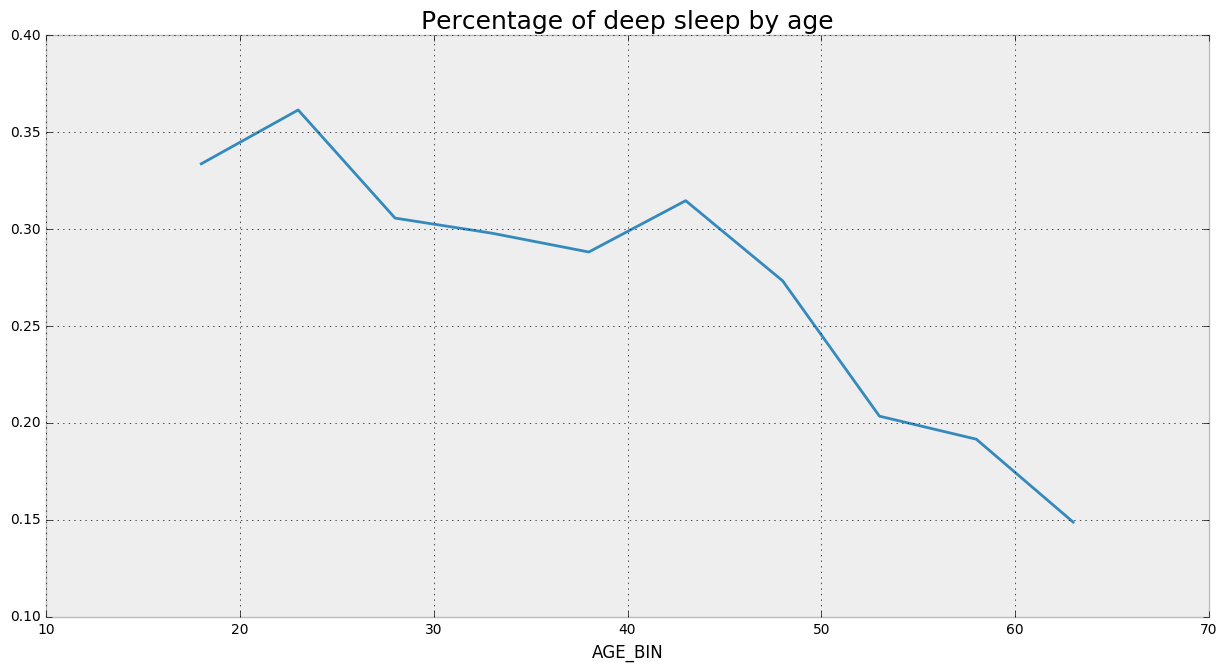

In [48]:
agg_ages["S3_PERC"].plot()
plt.axis('auto')
plt.title("Percentage of deep sleep by age", size=18)
#plt.savefig(path.join("figures", "max_deep_sleep.png"), format="png")

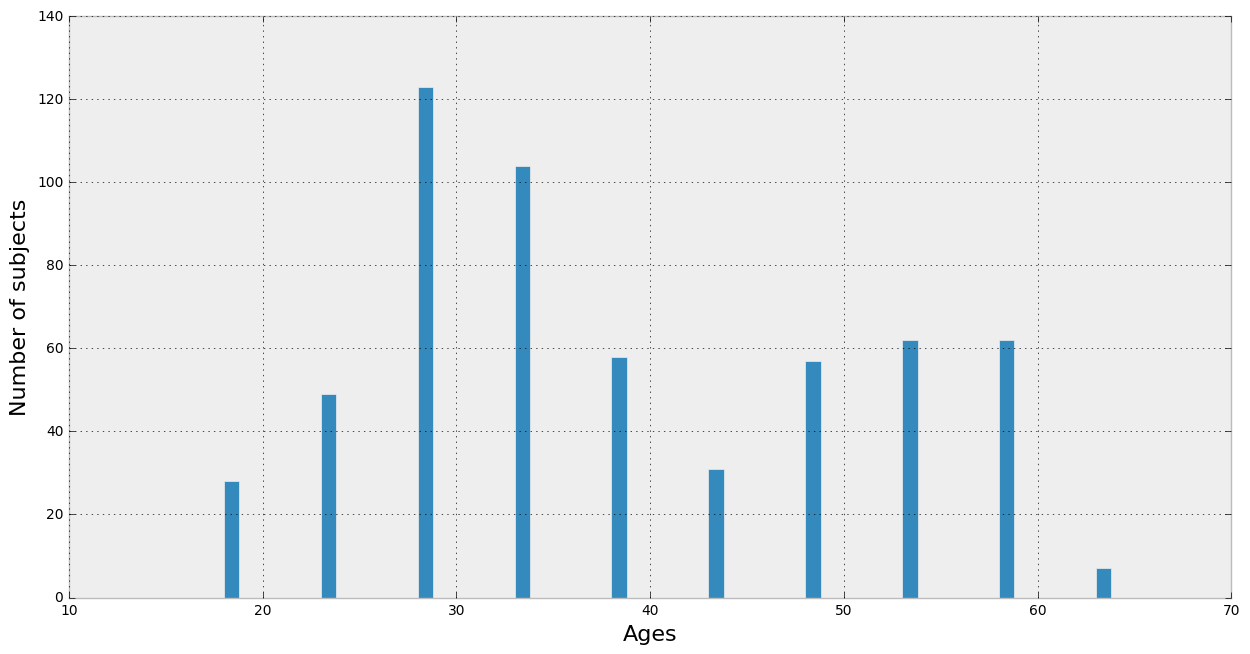

In [18]:
plt.bar(features_viz["AGE_BIN"].unique(), features_viz["AGE_BIN"].value_counts(), color=all_colors[0])
plt.xlabel("Ages", fontsize=16)
plt.ylabel("Number of subjects", fontsize=16)

# Random Forests

In [18]:
scorer = make_scorer(score_function, greater_is_better=False)

In [19]:
tuned_parameters = [{'n_estimators': [5, 10, 15, 20, 50, 100, 200, 500],
                     'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500],
                    'oob_score': [True, False]}]

In [20]:
X_train, y_train = features_train.values.astype(np.float64), ages.values.ravel()
X_test = features_test.values.astype(np.float64)
feature_names = list(features_train.columns)

In [21]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
reg = GridSearchCV(rf, tuned_parameters, cv=5, n_jobs=-1, verbose=1,
                       scoring=scorer)

In [23]:
reg.fit(X_train, y_train)

Fitting 5 folds for each of 112 candidates, totalling 560 fits


/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [5, 10, 15, 20, 50, 100, 200, 500], 'oob_score': [True, False], 'min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(score_function, greater_is_better=False),
       verbose=1)

In [24]:
print "best parameters"
print reg.best_params_
print "best score"
print -reg.best_score_

best parameters
{'n_estimators': 500, 'oob_score': True, 'min_samples_leaf': 1}
best score
24.0156484682


In [63]:
param_range = np.linspace(0,1,10)[1:]
reg2 = RandomForestRegressor(n_estimators=500, min_samples_leaf=1, oob_score=True, n_jobs=-1)
train_scores, test_scores = validation_curve(reg2, X_train, y_train, param_name="max_features", param_range=param_range,
    cv=10, scoring=scorer, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

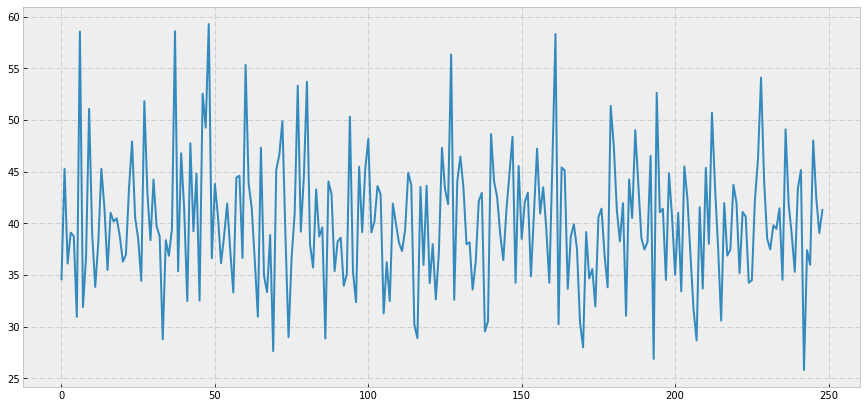

In [31]:
y_pred = reg.predict(X_test)
plt.plot(y_pred)

In [302]:
ages_pred = pd.DataFrame(np.round(y_pred), columns=["TARGET"], index=test.index)

In [303]:
ages_pred.to_csv("test_output_hypno.csv", sep=';')

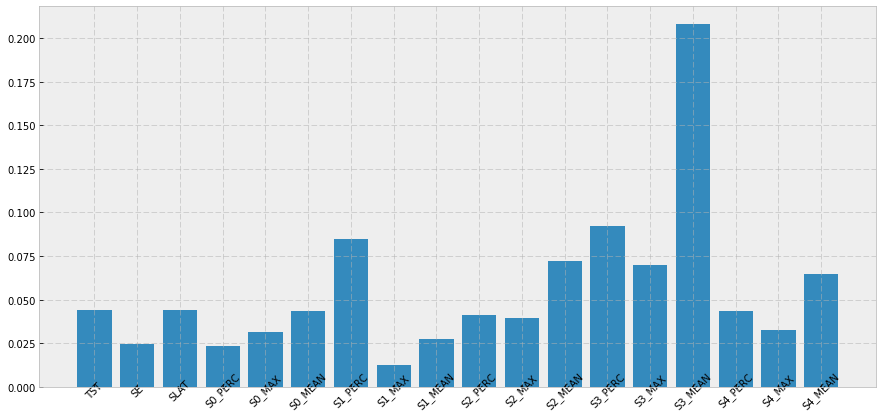

In [289]:
n_features = len(feature_names)
plt.bar(np.arange(n_features), reg.best_estimator_.feature_importances_)
axes = plt.gca()
a = axes.xaxis.set_ticks(range(n_features))
a = axes.xaxis.set_ticklabels(feature_names, rotation = 45, verticalalignment = 'center')